# Confounding Robust Policy Evaluation - model 3
We evaluate the worst case regret of a policy $\pi$ relative to a baseline policy $\pi_0$ as presented in [Kallus et al.](https://arxiv.org/pdf/1805.08593.pdf)  


The model we are using:  
Medical Treatment model as defined in Appendix A in https://causalai.net/mdp-causal.pdf  
Here, there is a slight difference in physician's policy to make it more asymmetrical. Here,  
$P(E_t = 1) = 0.3$ and $P(M_t = 1) = 0.75$

In [2]:
import numpy as np
def physicains_policy(St, Mt, Et):
    return (St+Mt+Et) % 2

In [3]:
# probability_yt_is_1 is a 4 dimensional array
# format: probability_yt_is_1[St][Mt][Et][Xt] is P(Yt = 1 | Xt, St, Mt, Et)
probability_yt_is_1 = np.zeros((2,2,2,2))
probability_yt_is_1[0][0][0][0] = 0.2
probability_yt_is_1[0][0][0][1] = 0.9
probability_yt_is_1[0][0][1][0] = 0.9
probability_yt_is_1[0][0][1][1] = 0.2
probability_yt_is_1[0][1][0][0] = 0.8
probability_yt_is_1[0][1][0][1] = 0.3
probability_yt_is_1[0][1][1][0] = 0.3
probability_yt_is_1[0][1][1][1] = 0.8

probability_yt_is_1[1][0][0][0] = 0.7
probability_yt_is_1[1][0][0][1] = 0.2
probability_yt_is_1[1][0][1][0] = 0.2
probability_yt_is_1[1][0][1][1] = 0.7
probability_yt_is_1[1][1][0][0] = 0.1
probability_yt_is_1[1][1][0][1] = 0.8
probability_yt_is_1[1][1][1][0] = 0.8
probability_yt_is_1[1][1][1][1] = 0.1

In [4]:
# transition_prob is a 2 dimensional array
# format: transition_prob[Xt][St] = P(St+1 = 0 | St, Xt)
transition_prob = np.zeros((2,2))
transition_prob[0][0] = 0.9
transition_prob[0][1] = 0.3
transition_prob[1][0] = 0.7
transition_prob[1][1] = 0.8

In [5]:
def get_Yt(St, Mt, Et, Xt):
    u = np.random.rand()
    if u < probability_yt_is_1[St][Mt][Et][Xt]:
        return 1
    return 0

In [6]:
def get_next_state(St, Xt):
    u = np.random.rand()
    if u < transition_prob[Xt][St]:
        return 0
    return 1

In [59]:
def get_et_and_mt():
    u1, u2 = np.random.rand(), np.random.rand()
    if u1 < 0.3:
        Et = 1
    else:
        Et = 0
    if u2 < 0.75:
        Mt = 1
    else:
        Mt = 0
    return Et, Mt

# Generate Data from model

In [8]:
import pandas as pd

data_df = pd.DataFrame()

In [9]:
def generate_single_trajectory(patient_id):
    global data_df
    St = np.random.randint(2)
    for t in range(100):
        Et, Mt = get_et_and_mt()
        Xt = physicains_policy(St, Mt, Et)
        Yt = get_Yt(St, Mt, Et, Xt)
        data_df = data_df.append({'pt_id': patient_id,'t': t, 'St': St, 'Mt': Mt, 'Et': Et, 'Xt': Xt, 'Yt': Yt}, ignore_index=True)
        St = get_next_state(St, Xt)

In [16]:
for patient_id in range(1000):
    if patient_id % 100 == 0:
        print("Iteration number: ", patient_id)
    generate_single_trajectory(patient_id)

In [17]:
data_df.to_csv('/Users/faaiz/MDPUC/data-model3.csv')

### Divide the data into training and testing sets

In [18]:
patients = data_df['pt_id'].unique()
training = patients[np.random.randint(5, size = (len(patients))) != 4]
testing = patients[np.random.randint(5, size = (len(patients))) == 4]

train_data = data_df.loc[data_df['pt_id'].isin(training)].reset_index()
test_data = data_df.loc[data_df['pt_id'].isin(testing)].reset_index()

### Compute the physician's policy. 
We will use this as the baseline $\pi_0$ when calculating the worst case regret for our policy.

In [19]:
from util_functions import *

sums = compute_state_action_visits(train_data, n_states=2, n_actions=2)

In [20]:
physpol = (sums.T/((sums.sum(axis=1)==0) + (sums.sum(axis=1)))).T

Our policy $\pi$ is obtained by 'softening' the deterministic policy  
$\pi(X_t = 0 | S_t = 0) = 1$  
$\pi(X_t = 1 | S_t = 1) = 1$

In [21]:
pi = np.zeros((2,2))
pi[0][0] = 0.95
pi[0][1] = 0.05
pi[1][0] = 0.05
pi[1][1] = 0.95
pi

array([[0.95, 0.05],
       [0.05, 0.95]])

### Estimating nominal propensities $P[X_t = x | S_t = s]$ from data
We can just estimate this from the physician's policy

In [22]:
propensity = physpol

For the purposes of this analysis, we assume $\Gamma = 1.2$. We will calibrate the value of $\Gamma$ when doing a more careful analysis.  
Here $\Gamma$ is defined as a bound $\Gamma\geq1$, such that:  
$\Gamma^{-1}\leq\frac{(1-\tilde{e}_T(X))e_T(X,Y)}{\tilde{e}_T(X)(1-e_T(X,Y))}\leq\Gamma$  
here $\tilde{e}_T(X) = P(T=t | X=x)$  
and $e_T(X,Y)=P(T=t | X=x, Y(t) = y)$

We use **Theorem 11** in [Kallus et al.](https://arxiv.org/pdf/1805.08593.pdf) to calculate the worst case regret. In order to do this, we must first compute $r_i$, $a_i^\Gamma$ and $b_i^\Gamma$ values as defined in the paper.

In [23]:
gamma = 1.2
cr_data = train_data.copy()
for index, row in cr_data.iterrows():
    cr_data.at[index, 'r'] = (physpol[int(row['St'])][int(row['Xt'])]-pi[int(row['St'])][int(row['Xt'])])*row['Yt']
    cr_data.at[index, 'a'] = 1 + 1/gamma*(1/propensity[int(row['St'])][int(row['Xt'])] - 1)
    cr_data.at[index, 'b'] = 1 + gamma*(1/propensity[int(row['St'])][int(row['Xt'])] - 1)
    

In [24]:
cr_data.head()

,index,Et,Mt,St,Xt,Yt,pt_id,t,r,a,b
0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.000000,1.551680,1.794420
1,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.551679,2.258781,2.812644
2,2,0.0,0.0,0.0,0.0,0.0,0.0,2.0,-0.000000,2.258781,2.812644
3,3,0.0,0.0,0.0,0.0,0.0,0.0,3.0,-0.000000,2.258781,2.812644
4,4,0.0,1.0,0.0,1.0,1.0,0.0,4.0,0.551679,1.551680,1.794420


In [25]:
cr_data_sorted = cr_data.sort_values(by='r').reset_index()

In [26]:
cr_data_sorted.head()

,level_0,index,Et,Mt,St,Xt,Yt,pt_id,t,r,a,b
0,16864,21264,1.0,1.0,0.0,0.0,1.0,212.0,64.0,-0.551679,2.258781,2.812644
1,6909,9209,1.0,1.0,0.0,0.0,1.0,92.0,9.0,-0.551679,2.258781,2.812644
2,10884,13884,0.0,0.0,0.0,0.0,1.0,138.0,84.0,-0.551679,2.258781,2.812644
3,24986,31186,0.0,0.0,0.0,0.0,1.0,311.0,86.0,-0.551679,2.258781,2.812644
4,13817,17217,1.0,1.0,0.0,0.0,1.0,172.0,17.0,-0.551679,2.258781,2.812644


In [27]:
def compute_lambda(k, data_sorted):
    num = ((data_sorted.index<k)*(data_sorted['a']*data_sorted['r'])).sum() +\
    ((data_sorted.index>=k)*(data_sorted['b']*data_sorted['r'])).sum()
    den = ((data_sorted.index<k)*data_sorted['a']).sum() +\
    ((data_sorted.index>=k)*data_sorted['b']).sum()
    return num/den    

As proved in the paper, the worst case regret estimate $\hat{\bar{Q}}(r;W_n^\Gamma) = \lambda(k^*)$  
where $k^* = \inf\{k=1,\dots,n+1:\lambda(k)<\lambda(k-1)\}$

In [28]:
lbd = compute_lambda(0, cr_data_sorted)
next_lbd = compute_lambda(1, cr_data_sorted)
i = 2
while i < len(cr_data_sorted) and  lbd <= next_lbd:
    lbd = next_lbd
    next_lbd = compute_lambda(i, cr_data_sorted)
    i += 1
if next_lbd < lbd:
    print('Worst case regret is', next_lbd)
else:
    print('k* is infinity')

Worst case regret is 0.014751351154487691


# Bring this all together in a function 

In [29]:
def compute_worst_case_regret(data, pi, pi0, gamma):
    n_states = len(pi)
    n_actions = len(pi[0])
    sums = compute_state_action_visits(data, n_states, n_actions)
    physpol = (sums.T/((sums.sum(axis=1)==0) + (sums.sum(axis=1)))).T
    propensity = physpol
    cr_data = data.copy()
    for index, row in cr_data.iterrows():
        cr_data.at[index, 'r'] = (physpol[int(row['St'])][int(row['Xt'])]-pi[int(row['St'])][int(row['Xt'])])*row['Yt']
        cr_data.at[index, 'a'] = 1 + 1/gamma*(1/propensity[int(row['St'])][int(row['Xt'])] - 1)
        cr_data.at[index, 'b'] = 1 + gamma*(1/propensity[int(row['St'])][int(row['Xt'])] - 1)
    cr_data_sorted = cr_data.sort_values(by='r').reset_index()
    lbd = compute_lambda(0, cr_data_sorted)
    next_lbd = compute_lambda(1, cr_data_sorted)
    i = 2
    while i < len(cr_data_sorted) and  lbd <= next_lbd:
        lbd = next_lbd
        next_lbd = compute_lambda(i, cr_data_sorted)
        i += 1
    if next_lbd < lbd:
        print('Worst case regret is', next_lbd)
        return next_lbd
    else:
        print('k* is infinity')
        return None

Let's try the same with policy $\pi$ obtained by 'softening' the deterministic policy  
$\pi(X_t = 1 | S_t = 0) = 1$  
$\pi(X_t = 0 | S_t = 1) = 1$

In [30]:
pi = np.zeros((2,2))
pi[0][0] = 0.05
pi[0][1] = 0.95
pi[1][0] = 0.95
pi[1][1] = 0.05
pi

array([[0.05, 0.95],
       [0.95, 0.05]])

In [31]:
compute_worst_case_regret(train_data, pi, physpol, gamma=1.2)

Worst case regret is 0.005962859346932289


0.005962859346932289

### Change the degree of unmeasured confounding
Now let's assume that we only have access to $S_t$ and $E_t$. $M_t$ is an unobserved confounder. In this case, the state space has 4 states. The action space remains unchanged.

In [32]:
train_data_model2 = train_data.copy()
train_data_model2.head()

,index,Et,Mt,St,Xt,Yt,pt_id,t
0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,4,0.0,1.0,0.0,1.0,1.0,0.0,4.0


In [33]:
train_data_model2['St'] = train_data_model2['St'] + 2*train_data_model2['Et']
train_data_model2.drop(columns = ['Et', 'Mt'], inplace=True)
train_data_model2.head()

,index,St,Xt,Yt,pt_id,t
0,0,0.0,1.0,0.0,0.0,0.0
1,1,0.0,0.0,1.0,0.0,1.0
2,2,0.0,0.0,0.0,0.0,2.0
3,3,0.0,0.0,0.0,0.0,3.0
4,4,0.0,1.0,1.0,0.0,4.0


### Optimal policy $\pi^*$
We know from the complete model dynamics that the optimal policy $\pi^*$ in this case is:  
$(S_t, E_t)$ -> Optimal Action  
(0,0) -> 0  
(0,1) -> 1  
(1,0) -> 1  
(1,1) -> 0

In [34]:
def soften_deterministic_policy(policy):
    p = 0.05
    n_states = len(policy)
    n_actions = len(policy[0])
    for i in range(len(policy)):
        for j in range(len(policy[i])):
            if policy[i][j] == 0:
                policy[i][j] = p/(n_actions-1)
            elif policy[i][j] == 1:
                policy[i][j] = 1-p
    return policy

A policy which always picks action 0 must have higher regret than the optimal policy $\pi^*$ relative to the physician's policy.

In [35]:
pi = np.zeros((4,2))
pi[0][0] = 1
pi[1][0] = 1
pi[2][0] = 1
pi[3][0] = 1
soften_deterministic_policy(pi)

array([[0.95, 0.05],
       [0.95, 0.05],
       [0.95, 0.05],
       [0.95, 0.05]])

In [36]:
sums = compute_state_action_visits(train_data_model2, n_states=4, n_actions=2)
physpol = (sums.T/((sums.sum(axis=1)==0) + (sums.sum(axis=1)))).T
physpol

array([[0.2468884 , 0.7531116 ],
       [0.75356619, 0.24643381],
       [0.74812757, 0.25187243],
       [0.25157401, 0.74842599]])

In [37]:
compute_worst_case_regret(train_data_model2, soften_deterministic_policy(pi), physpol, gamma=1.2)

Worst case regret is 0.025080322071306414


0.025080322071306414

In [73]:
pi_star = np.zeros((4,2))
pi_star[0][0] = 1
pi_star[1][1] = 1
pi_star[2][1] = 1
pi_star[3][0] = 1

In [74]:
compute_worst_case_regret(train_data_model2, soften_deterministic_policy(pi_star), physpol, gamma=1.2)

Worst case regret is 0.028842418496454875


0.028842418496454875

Repeat this with policy $\pi$ which is complement to the optimal policy $\pi^*$.  
This is, of course, the worst policy in terms of value.

In [75]:
pi = np.zeros((4,2))
pi[0][1] = 1
pi[1][0] = 1
pi[2][0] = 1
pi[3][1] = 1

In [76]:
compute_worst_case_regret(train_data_model2, soften_deterministic_policy(pi), physpol, gamma=1.2)

Worst case regret is -8.5959956188857e-05


-8.5959956188857e-05

Compute worst case regret for a uniform policy

In [42]:
pi = np.ones((4,2))*0.5
pi

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]])

In [43]:
compute_worst_case_regret(train_data_model2, pi, physpol, gamma=1.2)

Worst case regret is 0.01033874507388746


0.01033874507388746

### Policy evaluations and worst case regret under unobserved confounding
We do a systematic analysis of all deterministic policies, comparing their value (using Weighted Importance Sampling, assuming no unobserved confounding) to their worst case regret, relative to the physician's policy

In [46]:
def get_all_deterministic_policies(n_states, n_actions):
    result = []
    for i in range(n_actions**n_states):
        policy = np.zeros(n_states)
        policy[0] = i%2 
        policy[1] = ((i-policy[0])/2) % 2 
        policy[2] = ((i-policy[0]-2*policy[1])/4) % 2
        policy[3] = ((i-policy[0]-2*policy[1] - 4*policy[2])/8) % 2
        result.append(policy)
    return result

In [48]:
def turn_policy_into_softened_matrix(policy, n_actions):
    pi = np.zeros((len(policy), n_actions))
    for s in range(len(policy)):
        pi[s][int(policy[s])] = 1
    return soften_deterministic_policy(pi)

In [55]:
from offpolicy_eval import *

results_df = pd.DataFrame()

n_states = 4
n_actions = 2

policies = get_all_deterministic_policies(n_states, n_actions)

for pi in policies:
    _, bootwis_estimator = evaluate_policy(train_data_model2, pi, n_states, n_actions, 0.99, n_iters=50)
    pi_mat = turn_policy_into_softened_matrix(pi, n_actions)
    regret = compute_worst_case_regret(train_data_model2, pi_mat, physpol, gamma=1.2)
    results_df = results_df.append({'policy': pi, 'bootwis_estimator': bootwis_estimator.mean(), 'worst_case_regret': regret}, ignore_index=True)
    
results_df

,bootwis_estimator,policy,worst_case_regret
0,16.849613,"[0.0, 0.0, 0.0, 0.0]",0.025080
1,14.611379,"[1.0, 0.0, 0.0, 0.0]",-0.003182
2,12.553125,"[0.0, 1.0, 0.0, 0.0]",0.016080
3,15.983051,"[1.0, 1.0, 0.0, 0.0]",-0.011051
4,16.102709,"[0.0, 0.0, 1.0, 0.0]",0.037798
5,16.761323,"[1.0, 0.0, 1.0, 0.0]",0.008874
6,11.933816,"[0.0, 1.0, 1.0, 0.0]",0.028842
7,12.614686,"[1.0, 1.0, 1.0, 0.0]",-0.000154
8,14.101396,"[0.0, 0.0, 0.0, 1.0]",0.028615
9,12.649414,"[1.0, 0.0, 0.0, 1.0]",-0.000086


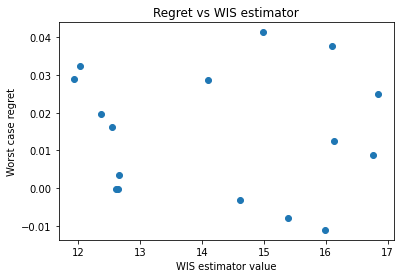

In [58]:
import matplotlib.pyplot as plt

x = results_df['bootwis_estimator']
y = results_df['worst_case_regret']
plt.scatter(x, y)
plt.xlabel('WIS estimator value')
plt.ylabel('Worst case regret')
plt.title('Regret vs WIS estimator')
plt.show()

In [62]:
def compute_true_policy_value(policy, num_iter, gamma):
    value = 0
    for i in range(num_iter):
        Et, Mt = get_et_and_mt()
        St = np.random.randint(2)
        reward = 0
        for t in range(100):
            Xt = int(policy[int(St+2*Et)])
            Yt = get_Yt(St, Mt, Et, Xt)
            reward += (gamma**t)*Yt
            St = get_next_state(St, Xt)
            Et, Mt = get_et_and_mt()
        value += reward
    value = value/num_iter
    return value

In [70]:
for index, row in results_df.iterrows():
    results_df.at[index, 'true_value'] = compute_true_policy_value(row['policy'], 10000, 1)
    print("Number of values computed: ", index)

Number of values computed:  0
Number of values computed:  1
Number of values computed:  2
Number of values computed:  3
Number of values computed:  4
Number of values computed:  5
Number of values computed:  6
Number of values computed:  7
Number of values computed:  8
Number of values computed:  9
Number of values computed:  10
Number of values computed:  11
Number of values computed:  12
Number of values computed:  13
Number of values computed:  14
Number of values computed:  15


In [77]:
results_df

,bootwis_estimator,policy,worst_case_regret,true_value
0,16.849613,"[0.0, 0.0, 0.0, 0.0]",0.025080,53.2994
1,14.611379,"[1.0, 0.0, 0.0, 0.0]",-0.003182,41.5312
2,12.553125,"[0.0, 1.0, 0.0, 0.0]",0.016080,59.8348
3,15.983051,"[1.0, 1.0, 0.0, 0.0]",-0.011051,50.4893
4,16.102709,"[0.0, 0.0, 1.0, 0.0]",0.037798,55.2122
5,16.761323,"[1.0, 0.0, 1.0, 0.0]",0.008874,43.9116
6,11.933816,"[0.0, 1.0, 1.0, 0.0]",0.028842,64.8788
7,12.614686,"[1.0, 1.0, 1.0, 0.0]",-0.000154,55.4327
8,14.101396,"[0.0, 0.0, 0.0, 1.0]",0.028615,52.6289
9,12.649414,"[1.0, 0.0, 0.0, 1.0]",-0.000086,38.0785


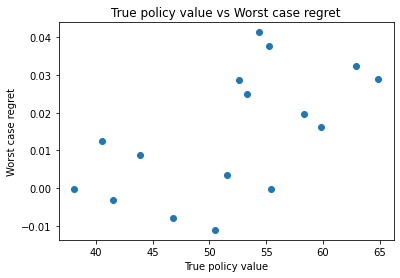

In [71]:
import matplotlib.pyplot as plt

x = results_df['true_value']
y = results_df['worst_case_regret']
plt.scatter(x, y)
plt.xlabel('True policy value')
plt.ylabel('Worst case regret')
plt.title('True policy value vs Worst case regret')
plt.show()

We do not see the downward trend in Worst case regret as True policy value increases. In fact from the results_df table above it is clear that the worst case regret for the optimal policy $\pi^*$ is quite high, whereas the regret of worst possible policy $\pi= [1,0,0,1]$ is very low.  
This shows that we cannot use worst case regret as a proxy to the policy value.

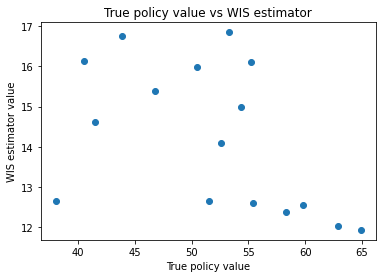

In [78]:
import matplotlib.pyplot as plt

x = results_df['true_value']
y = results_df['bootwis_estimator']
plt.scatter(x, y)
plt.xlabel('True policy value')
plt.ylabel('WIS estimator value')
plt.title('True policy value vs WIS estimator')
plt.show()

This confirms our suspicion that WIS estimator is not a good evaluation of the policy. The estimator value is small even for high true policy values.